# MNIST

In [2]:
from fastai.vision.all import *

Get MNIST sample data

In [3]:
URLs.MNIST_SAMPLE

'https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz'

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('/storage/data/mnist_sample')

Change base path to path and list files

In [5]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [6]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [7]:
(path/'train'/'7').ls()

(#6265) [Path('train/7/32208.png'),Path('train/7/79.png'),Path('train/7/54193.png'),Path('train/7/4545.png'),Path('train/7/2161.png'),Path('train/7/11473.png'),Path('train/7/3914.png'),Path('train/7/58565.png'),Path('train/7/8302.png'),Path('train/7/59871.png')...]

Create lists with locations of images for 3 and 7

In [8]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [9]:
im = Image.open(threes[1])
im

Some experimentation with data

In [10]:
array(im)[4:12,4:12]

array([[  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29, 150, 195],
       [  0,   0,   0,  48, 166, 224, 253, 253],
       [  0,  93, 244, 249, 253, 187,  46,  10],
       [  0, 107, 253, 253, 230,  48,   0,   0],
       [  0,   3,  20,  20,  15,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  14]], dtype=uint8)

In [11]:
tensor(im)[4:12,4:12]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29, 150, 195],
        [  0,   0,   0,  48, 166, 224, 253, 253],
        [  0,  93, 244, 249, 253, 187,  46,  10],
        [  0, 107, 253, 253, 230,  48,   0,   0],
        [  0,   3,  20,  20,  15,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  14]], dtype=torch.uint8)

In [12]:
three_df = pd.DataFrame(tensor(im)[4:20,4:20])
three_df.style.set_properties().background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2


### Simple approach to identify pictures

In [23]:
threes_list = [tensor(Image.open(o)) for o in threes]
sevens_list = [tensor(Image.open(o)) for o in sevens]
len(threes_list), len(sevens_list)

(6131, 6265)

<AxesSubplot:>

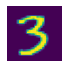

In [25]:
show_image(threes_list[1])

In [49]:
max([int(threes_list[i].max()) for i in range(len(threes_list))])

255

In [52]:
threes_stacked = torch.stack(threes_list).float()/255
sevens_stacked = torch.stack(sevens_list).float()/255
threes_stacked.shape, sevens_stacked.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

<AxesSubplot:>

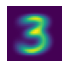

In [55]:
avg_three = threes_stacked.mean(0)
show_image(avg_three)

<AxesSubplot:>

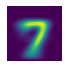

In [57]:
avg_seven = sevens_stacked.mean(0)
show_image(avg_seven)

Take one image and find diffences

In [60]:
(path/'valid'/'3').ls()

(#1010) [Path('valid/3/5309.png'),Path('valid/3/9812.png'),Path('valid/3/5635.png'),Path('valid/3/2072.png'),Path('valid/3/3094.png'),Path('valid/3/7075.png'),Path('valid/3/2069.png'),Path('valid/3/4638.png'),Path('valid/3/991.png'),Path('valid/3/323.png')...]

In [61]:
test_image = Image.open((path/'valid'/'3'/'5309.png'))
test_image

In [66]:
test_image_fin = (tensor(test_image).float()/255)

Find the error terms

In [71]:
l1_with_3 = (test_image_fin - avg_three).abs().mean()
l1_with_7 = (test_image_fin - avg_seven).abs().mean()
l1_with_3, l1_with_7

(tensor(0.1290), tensor(0.1769))

In [72]:
l2_with_3 = ((test_image_fin - avg_three)**2).abs().mean()
l2_with_7 = ((test_image_fin - avg_seven)**2).abs().mean()
l2_with_3, l2_with_7

(tensor(0.0561), tensor(0.1071))